Import libraries

In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import special
from pathlib import Path
import math
import scipy.stats as scs
import matplotlib.pyplot as plt

In [2]:
Nout = 100000  # number of out-of-sample scenarios
Nin = 5000     # number of in-sample scenarios
Ns = 5         # number of idiosyncratic scenarios for each systemic

C = 8          # number of credit states

# Read and parse instrument data
instr_data = np.array(pd.read_csv('instrum_data.csv', header=None))
instr_id = instr_data[:, 0]     # ID
driver = instr_data[:, 1]       # credit driver
beta = instr_data[:, 2]         # beta (sensitivity to credit driver)
recov_rate = instr_data[:, 3]   # expected recovery rate
value = instr_data[:, 4]        # value
prob = instr_data[:, 5:(5 + C)] # credit-state migration probabilities (default to AAA)
exposure = instr_data[:, 5 + C:5 + 2 * C]  # credit-state migration exposures (default to AAA)
retn = instr_data[:, 5 + 2 * C] # market returns

K = instr_data.shape[0]         # number of CPs

# Read matrix of correlations for credit drivers
rho = np.array(pd.read_csv('credit_driver_corr.csv', sep='\t', header=None))
# Cholesky decomp of rho (for generating correlated Normal random numbers)
sqrt_rho = np.linalg.cholesky(rho)

print('======= Credit Risk Model with Credit-State Migrations =======')
print('============== Monte Carlo Scenario Generation ===============')
print(' ')
print(' ')
print(' Number of out-of-sample Monte Carlo scenarios = ' + str(Nout))
print(' Number of in-sample Monte Carlo scenarios = ' + str(Nin))
print(' Number of counterparties = ' + str(K))
print(' ')

# Find credit-state for each counterparty<br>
# 8 = AAA, 7 = AA, 6 = A, 5 = BBB, 4 = BB, 3 = B, 2 = CCC, 1 = default

CS = np.argmax(prob, axis=1) + 1

# Account for default recoveries
exposure[:, 0] = (1 - recov_rate) * exposure[:, 0]

# Compute credit-state boundaries
CS_Bdry = scipy.special.ndtri((np.cumsum(prob[:, 0:C - 1], 1)))

======= Credit Risk Model with Credit-State Migrations =======
============== Monte Carlo Scenario Generation ===============
 
 
 Number of out-of-sample Monte Carlo scenarios = 100000
 Number of in-sample Monte Carlo scenarios = 5000
 Number of counterparties = 100
 


In [3]:
# -------- Insert your code here -------- #
num_drivers = len(rho)
filename_save_out = 'scen_out'
if Path(filename_save_out+'.npz').is_file():
    Losses_out = scipy.sparse.load_npz(filename_save_out + '.npz')
else:
    # Generating Scenarios
    y = np.zeros((Nout, num_drivers)) # systemic risk
    z = np.random.randn(K, 1) # idiosyncratic component
    Losses_out = np.zeros((Nout, K)) # losses for each counterparty under each scnario
    
    # -------- Insert your code here -------- #
    for s in range(1, Nout + 1): 
        nums = np.random.randn(num_drivers, 1) 
        y[s-1, :] = np.dot(sqrt_rho, nums).T
         
        # -------- Insert your code here -------- #
        for k in range (1, K+1):
            # compute credit driver for each company
            num_cd= int(driver[k-1])
            w = beta[k-1] * y[s-1, (num_cd - 1)] + np.sqrt(1 - beta[k-1]**2) * z[k - 1]
            # find the index of each w
            bd = sorted(np.append(w, CS_Bdry[k-1,:]))
            cp_index = np.argwhere(bd == w)
            
            Losses_out[s-1, k-1] = exposure[k-1, cp_index]
        
            
        # Calculated out-of-sample losses (100000 x 100)
        # Losses_out (sparse matrix)
#         Losses_out = #...

In [4]:
# Normal approximation computed from out-of-sample scenarios
mu_l = np.mean(Losses_out, axis=0).reshape((K))
var_l = np.cov(Losses_out, rowvar=False) # Losses_out as a sparse matrix

# Compute portfolio weights
portf_v = sum(value)  # portfolio value
w0 = []
w0.append(value / portf_v)   # asset weights (portfolio 1)
w0.append(np.ones((K)) / K)  # asset weights (portfolio 2)
x0 = []
x0.append((portf_v / value) * w0[0])  # asset units (portfolio 1)
x0.append((portf_v / value) * w0[1])  # asset units (portfolio 2)

# Quantile levels (99%, 99.9%)
alphas = np.array([0.99, 0.999])

VaRout = np.zeros((2, alphas.size))
VaRinN = np.zeros((2, alphas.size))
CVaRout = np.zeros((2, alphas.size))
CVaRinN = np.zeros((2, alphas.size))

for portN in range(2):
    # Compute VaR and CVaR
    for q in range(alphas.size):
        alf = alphas[q]
        # -------- Insert your code here -------- #
        # Sort loss data in increasing order
        loss_1d = sorted(np.dot(Losses_out, x0[portN]))
        # Compute portfolio mean loss mu_out
        mu_out = np.dot(mu_l, x0[portN])
        # Compute portfolio standard deviation of losses sigma_p_MC1
        sigma_out = np.std(loss_1d)
        # Compute Historical 1-day VaR from the data
        VaRout[portN, q] = loss_1d[int(math.ceil(Nout * alf)) - 1]
        # Compute Normal 1-day VaR from the data
        VaRinN[portN, q] = mu_out + scs.norm.ppf(alf) * sigma_out
        # Compute Historical 1-day CVaR from the data
        CVaRout[portN, q] = (1 / (Nout * (1 - alf))) * ((math.ceil(Nout * alf) - Nout * alf) * VaRout[portN, q] + sum(loss_1d[int(math.ceil(Nout * alf)):]))
        # Compute Normal 1-day CVaR from the data
        CVaRinN[portN, q] = mu_out + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 - alf)) * sigma_out


In [5]:
# Perform 100 trials
N_trials = 100

VaRinMC1 = {} # in-sample MC1 VaR
VaRinMC2 = {} # in-sample MC2 VaR
VaRinN1 = {} # in-sample Normal Distribution1 VaR
VaRinN2 = {} # in-sample Normal Distribution2 VaR
CVaRinMC1 = {} # in-sample MC1 CVaR
CVaRinMC2 = {} # in-sample MC2 CVaR
CVaRinN1 = {} # in-sample Normal Distribution1 CVaR
CVaRinN2 = {} # in-sample Normal Distribution2 CVaR

for portN in range(2):
    for q in range(alphas.size):
        VaRinMC1[portN, q] = np.zeros(N_trials)
        VaRinMC2[portN, q] = np.zeros(N_trials)
        VaRinN1[portN, q] = np.zeros(N_trials)
        VaRinN2[portN, q] = np.zeros(N_trials)
        CVaRinMC1[portN, q] = np.zeros(N_trials)
        CVaRinMC2[portN, q] = np.zeros(N_trials)
        CVaRinN1[portN, q] = np.zeros(N_trials)
        CVaRinN2[portN, q] = np.zeros(N_trials)
        
for tr in range(1, N_trials + 1):
    # Monte Carlo approximation 1
    yin_MC1 = np.zeros((int(np.ceil(Nin / Ns)), num_drivers)) # 1000 * 50
    Losses_inMC1 = np.zeros((Nin, K)) # 100 counterparties with 5000 scenarios
    # -------- Insert your code here -------- #
    for s in range(1, np.int32(np.ceil(Nin / Ns) + 1)): # systemic scenarios
        nums = np.random.randn(num_drivers, 1)
        yin_MC1[s-1, :] = np.dot(sqrt_rho, nums).T
        # -------- Insert your code here -------- #
        for si in range(1, Ns + 1): # idiosyncratic scenarios for each systemic
            # -------- Insert your code here -------- #
            zin_MC1 = np.random.randn(K, 1)
            
    # Calculate losses for MC1 approximation (5000 x 100)
    # Losses_inMC1
            for k in range(1, K + 1):
                num_cd= int(driver[k-1])
                win_MC1 = beta[k-1] * yin_MC1[s-1, (num_cd - 1)] + np.sqrt(1 - beta[k-1]**2) * zin_MC1[k - 1]
                # find the index of each w
                bdin_MC1 = sorted(np.append(win_MC1, CS_Bdry[k-1,:]))
                cp_index = np.argwhere(bdin_MC1 == win_MC1)
            
                Losses_inMC1[5*s + si - 6, k-1] = exposure[k-1, cp_index]
   
    # Monte Carlo approximation 2
    
    # -------- Insert your code here -------- #
    yin_MC2 = np.zeros((Nin, num_drivers)) # 5000 * 50
    Losses_inMC2 = np.zeros((Nin, K))
    
    for s in range(1, Nin + 1): # systemic scenarios (1 idiosyncratic scenario for each systemic)
        # -------- Insert your code here -------- #
        nums = np.random.randn(num_drivers, 1)
        yin_MC2[s-1, :] = np.dot(sqrt_rho, nums).T
        zin_MC2 = np.random.randn(K,1)
        
        for k in range(1, K + 1):
            num_cd = int(driver[k-1])
            win_MC2 = beta[k-1] * yin_MC2[s-1, (num_cd - 1)] + np.sqrt(1 - beta[k-1]**2) * zin_MC2[k-1]
            # find the index of each w
            bdin_MC2 = sorted(np.append(win_MC2, CS_Bdry[k-1,:]))
            cp_index = np.argwhere(bdin_MC2 == win_MC2)
            
            Losses_inMC2[s-1, k-1] = exposure[k-1, cp_index]
    # Calculated losses for MC2 approximation (5000 x 100)
    # Losses_inMC2
    
    # Compute VaR and CVaR
    for portN in range(2):
        for q in range(alphas.size):
            alf = alphas[q]
            # -------- Insert your code here -------- #
            # Compute portfolio loss
            portf_loss_inMC1 = sorted(np.dot(Losses_inMC1, x0[portN])) # losses of portfolio for each scenario
            portf_loss_inMC2 = sorted(np.dot(Losses_inMC2, x0[portN]))
            mu_MC1 = np.mean(Losses_inMC1, axis=0).reshape((K)) # average loss for each counterparty in 5000 scenarios
            var_MC1 = np.cov(Losses_inMC1, rowvar=False)
            mu_MC2 = np.mean(Losses_inMC2, axis=0).reshape((K))
            var_MC2 = np.cov(Losses_inMC2, rowvar=False)
            # Compute portfolio mean loss mu_p_MC1 and portfolio standard deviation of losses sigma_p_MC1
            # Compute portfolio mean loss mu_p_MC2 and portfolio standard deviation of losses sigma_p_MC2
            # Compute VaR and CVaR for the current trial
            mu_p_MC1 = np.dot(mu_MC1, x0[portN]) # average loss for each counterparty times the number of bonds of each counterparty 
            sigma_p_MC1 = np.std(portf_loss_inMC1)
            mu_p_MC2 = np.dot(mu_MC2, x0[portN])
            sigma_p_MC2 = np.std(portf_loss_inMC2)
            VaRinMC1[portN, q][tr - 1] = portf_loss_inMC1[int(math.ceil(Nin * alf)) - 1]
            VaRinMC2[portN, q][tr - 1] = portf_loss_inMC2[int(math.ceil(Nin * alf)) - 1]
            VaRinN1[portN, q][tr - 1] =  mu_p_MC1 + scs.norm.ppf(alf) * sigma_p_MC1
            VaRinN2[portN, q][tr - 1] =  mu_p_MC2 + scs.norm.ppf(alf) * sigma_p_MC2
            CVaRinMC1[portN, q][tr - 1] = (1 / (Nin * (1 - alf))) * ((math.ceil(Nin * alf) - Nin * alf) *  VaRinMC1[portN, q][tr - 1] + sum(portf_loss_inMC1[int(math.ceil(Nin * alf)):]))
            CVaRinMC2[portN, q][tr - 1] = (1 / (Nin * (1 - alf))) * ((math.ceil(Nin * alf) - Nin * alf) *  VaRinMC2[portN, q][tr - 1] + sum(portf_loss_inMC2[int(math.ceil(Nin * alf)):]))
            CVaRinN1[portN, q][tr - 1] =  mu_p_MC1 + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 - alf)) * sigma_p_MC1
            CVaRinN2[portN, q][tr - 1] =  mu_p_MC2 + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 - alf)) * sigma_p_MC2

In [6]:
# Display VaR and CVaR
for portN in range(2):
    print('\nPortfolio {}:\n'.format(portN + 1))
    for q in range(alphas.size):
        alf = alphas[q]
        print('Out-of-sample: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRout[portN, q], 100 * alf, CVaRout[portN, q]))
        print('In-sample MC1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC1[portN, q]), 100 * alf, np.mean(CVaRinMC1[portN, q])))
        print('In-sample MC2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC2[portN, q]), 100 * alf, np.mean(CVaRinMC2[portN, q])))
        print('In-sample No: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRinN[portN, q], 100 * alf, CVaRinN[portN, q]))
        print('In-sample N1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinN1[portN, q]), 100 * alf, np.mean(CVaRinN1[portN, q])))
        print('In-sample N2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f\n' % (
        100 * alf, np.mean(VaRinN2[portN, q]), 100 * alf, np.mean(CVaRinN2[portN, q])))


Portfolio 1:

Out-of-sample: VaR 99.0% = $43408181.86, CVaR 99.0% = $51611512.56
In-sample MC1: VaR 99.0% = $37007254.43, CVaR 99.0% = $44404657.90
In-sample MC2: VaR 99.0% = $37102411.94, CVaR 99.0% = $44723633.12
In-sample No: VaR 99.0% = $33261479.09, CVaR 99.0% = $36692437.53
In-sample N1: VaR 99.0% = $26105695.06, CVaR 99.0% = $28986043.43
In-sample N2: VaR 99.0% = $26193951.43, CVaR 99.0% = $29082442.80

Out-of-sample: VaR 99.9% = $64650772.14, CVaR 99.9% = $73334002.09
In-sample MC1: VaR 99.9% = $53691650.81, CVaR 99.9% = $60660211.68
In-sample MC2: VaR 99.9% = $53750649.44, CVaR 99.9% = $61269623.10
In-sample No: VaR 99.9% = $40995666.23, CVaR 99.9% = $43798799.43
In-sample N1: VaR 99.9% = $32598677.62, CVaR 99.9% = $34951955.94
In-sample N2: VaR 99.9% = $32705290.23, CVaR 99.9% = $35065221.49


Portfolio 2:

Out-of-sample: VaR 99.0% = $36737045.28, CVaR 99.0% = $44496393.51
In-sample MC1: VaR 99.0% = $27432271.76, CVaR 99.0% = $33272131.76
In-sample MC2: VaR 99.0% = $27338842

## Plot 1 Portfolio 1 

## Out-of-Sample vs Normal model at 99% and 99.9% level

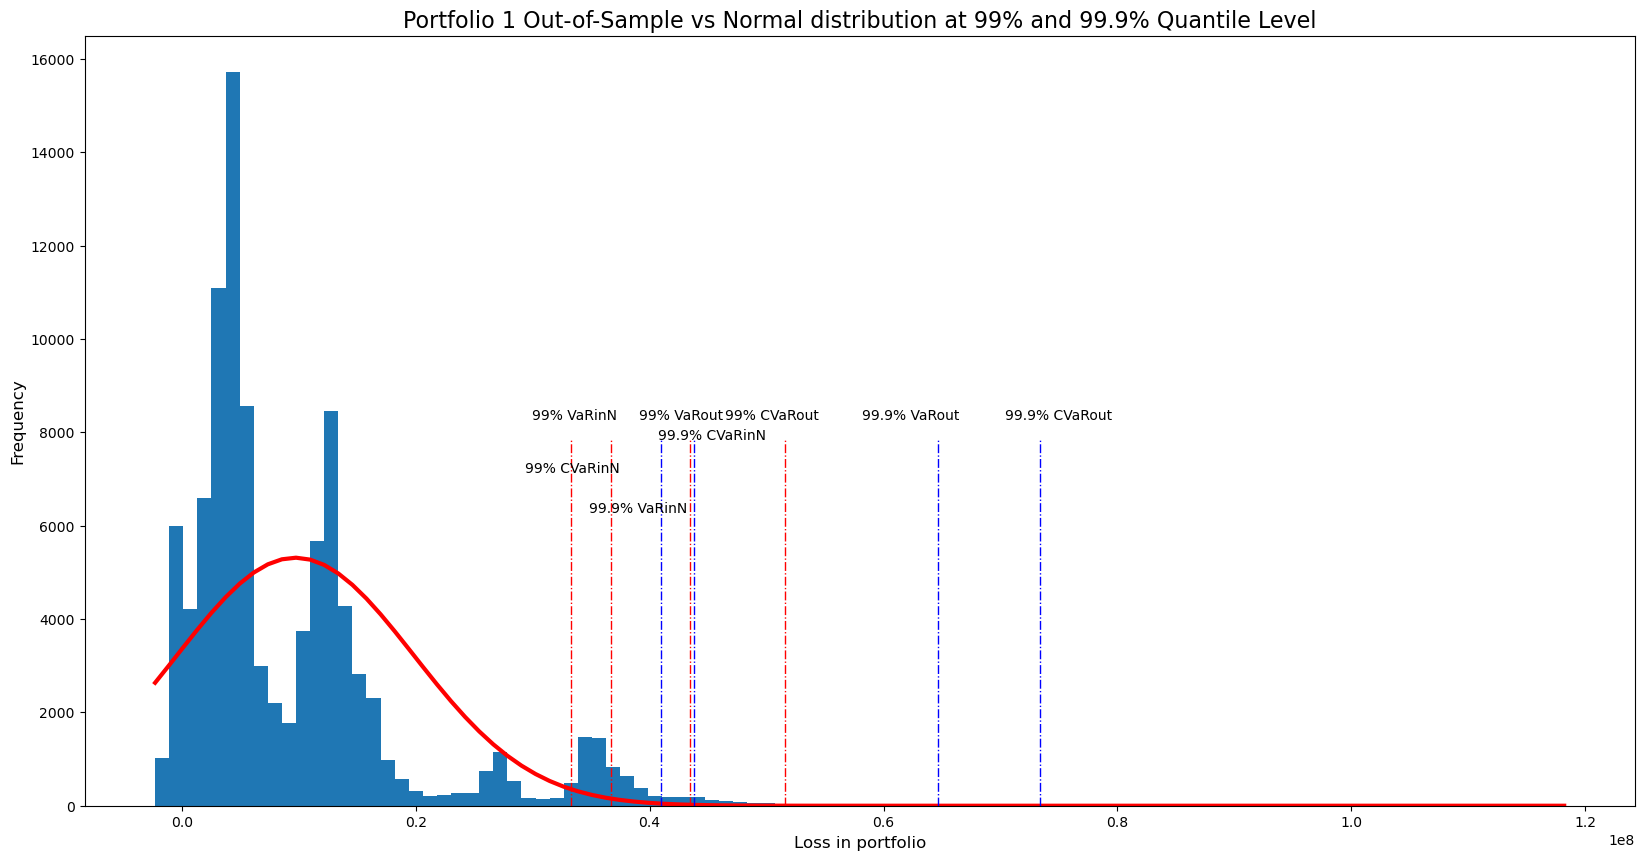

In [7]:
plt.figure(figsize=(20, 10))

frequencyCounts, binLocations, patches = plt.hist(np.dot(Losses_out,x0[0]), 100)
normf= (1 / (np.std(np.dot(Losses_out,x0[0])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations-np.mean(np.dot(Losses_out,x0[0]))) / np.std(np.dot(Losses_out,x0[0]))) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)

plt.plot(binLocations, normf, color='r', linewidth=3.0)
plt.plot([VaRout[0,0], VaRout[0,0]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([VaRout[0,1], VaRout[0,1]], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot([VaRinN[0,0], VaRinN[0,0]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([VaRinN[0,1], VaRinN[0,1]], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot([CVaRout[0,0], CVaRout[0,0]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([CVaRout[0,1], CVaRout[0,1]], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot([CVaRinN[0,0], CVaRinN[0,0]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([CVaRinN[0,1], CVaRinN[0,1]], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')


plt.text(0.9 * VaRout[0,0], max(frequencyCounts) / 1.9, '99% VaRout')
plt.text(0.9 * VaRout[0,1], max(frequencyCounts) / 1.9, '99.9% VaRout')
plt.text(0.9 * VaRinN[0,0], max(frequencyCounts) / 1.9, '99% VaRinN')
plt.text(0.85 * VaRinN[0,1], max(frequencyCounts) / 2.5, '99.9% VaRinN')
plt.text(0.9 * CVaRout[0,0], max(frequencyCounts) / 1.9, '99% CVaRout')
plt.text(0.96 * CVaRout[0,1], max(frequencyCounts) / 1.9, '99.9% CVaRout')
plt.text(0.8 * CVaRinN[0,0], max(frequencyCounts) / 2.2, '99% CVaRinN')
plt.text(0.93 * CVaRinN[0,1], max(frequencyCounts) / 2.0, '99.9% CVaRinN')
plt.xlabel('Loss in portfolio',fontsize=12)
plt.ylabel('Frequency',fontsize=12)
plt.title('Portfolio 1 Out-of-Sample vs Normal distribution at 99% and 99.9% Quantile Level',fontsize=16)
plt.show()

## Portfolio 1 MC1 vs Normal Distribution at 99% and 99.9% Quantile Level

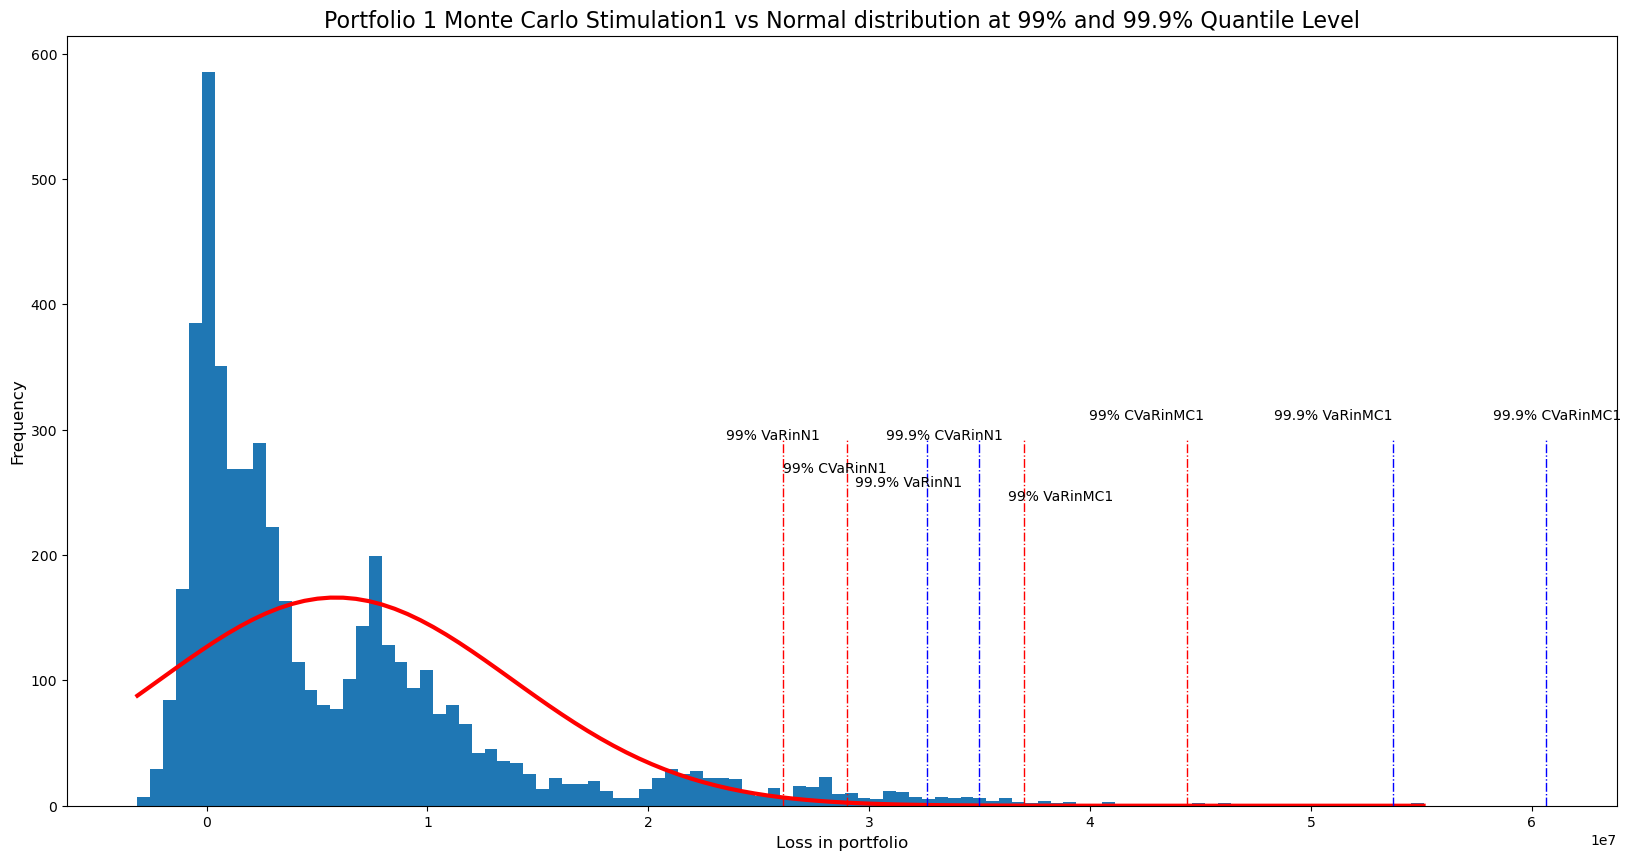

In [8]:
plt.figure(figsize=(20, 10))

frequencyCounts, binLocations, patches = plt.hist(np.dot(Losses_inMC1,x0[0]), 100)
normf= (1 / (np.std(np.dot(Losses_inMC1,x0[0])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations-np.mean(np.dot(Losses_inMC1,x0[0]))) / np.std(np.dot(Losses_inMC1,x0[0]))) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)

plt.plot(binLocations, normf, color='r', linewidth=3.0)
plt.plot([np.mean(VaRinMC1[0,0]), np.mean(VaRinMC1[0,0])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([np.mean(VaRinMC1[0,1]), np.mean(VaRinMC1[0,1])], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot([np.mean(VaRinN1[0,0]), np.mean(VaRinN1[0,0])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([np.mean(VaRinN1[0,1]), np.mean(VaRinN1[0,1])], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinMC1[0,0]), np.mean(CVaRinMC1[0,0])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinMC1[0,1]), np.mean(CVaRinMC1[0,1])], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinN1[0,0]), np.mean(CVaRinN1[0,0])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinN1[0,1]), np.mean(CVaRinN1[0,1])], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')


plt.text(0.98 * np.mean(VaRinMC1[0,0]), max(frequencyCounts) / 2.4, '99% VaRinMC1')
plt.text(0.9 * np.mean(VaRinMC1[0,1]), max(frequencyCounts) / 1.9, '99.9% VaRinMC1')
plt.text(0.9 * np.mean(VaRinN1[0,0]), max(frequencyCounts) / 2.0, '99% VaRinN1')
plt.text(0.9 * np.mean(VaRinN1[0,1]), max(frequencyCounts) / 2.3, '99.9% VaRinN1')
plt.text(0.9 * np.mean(CVaRinMC1[0,0]), max(frequencyCounts) / 1.9, '99% CVaRinMC1')
plt.text(0.96 * np.mean(CVaRinMC1[0,1]), max(frequencyCounts) / 1.9, '99.9% CVaRinMC1')
plt.text(0.9 * np.mean(CVaRinN1[0,0]), max(frequencyCounts) / 2.2, '99% CVaRinN1')
plt.text(0.88 * np.mean(CVaRinN1[0,1]), max(frequencyCounts) / 2.0, '99.9% CVaRinN1')
plt.xlabel('Loss in portfolio',fontsize=12)
plt.ylabel('Frequency',fontsize=12)
plt.title('Portfolio 1 Monte Carlo Stimulation1 vs Normal distribution at 99% and 99.9% Quantile Level',fontsize=16)
plt.show()

## Portfolio 1 MC2 vs Normal Distribution at 99% and 99.9% Quantile Level

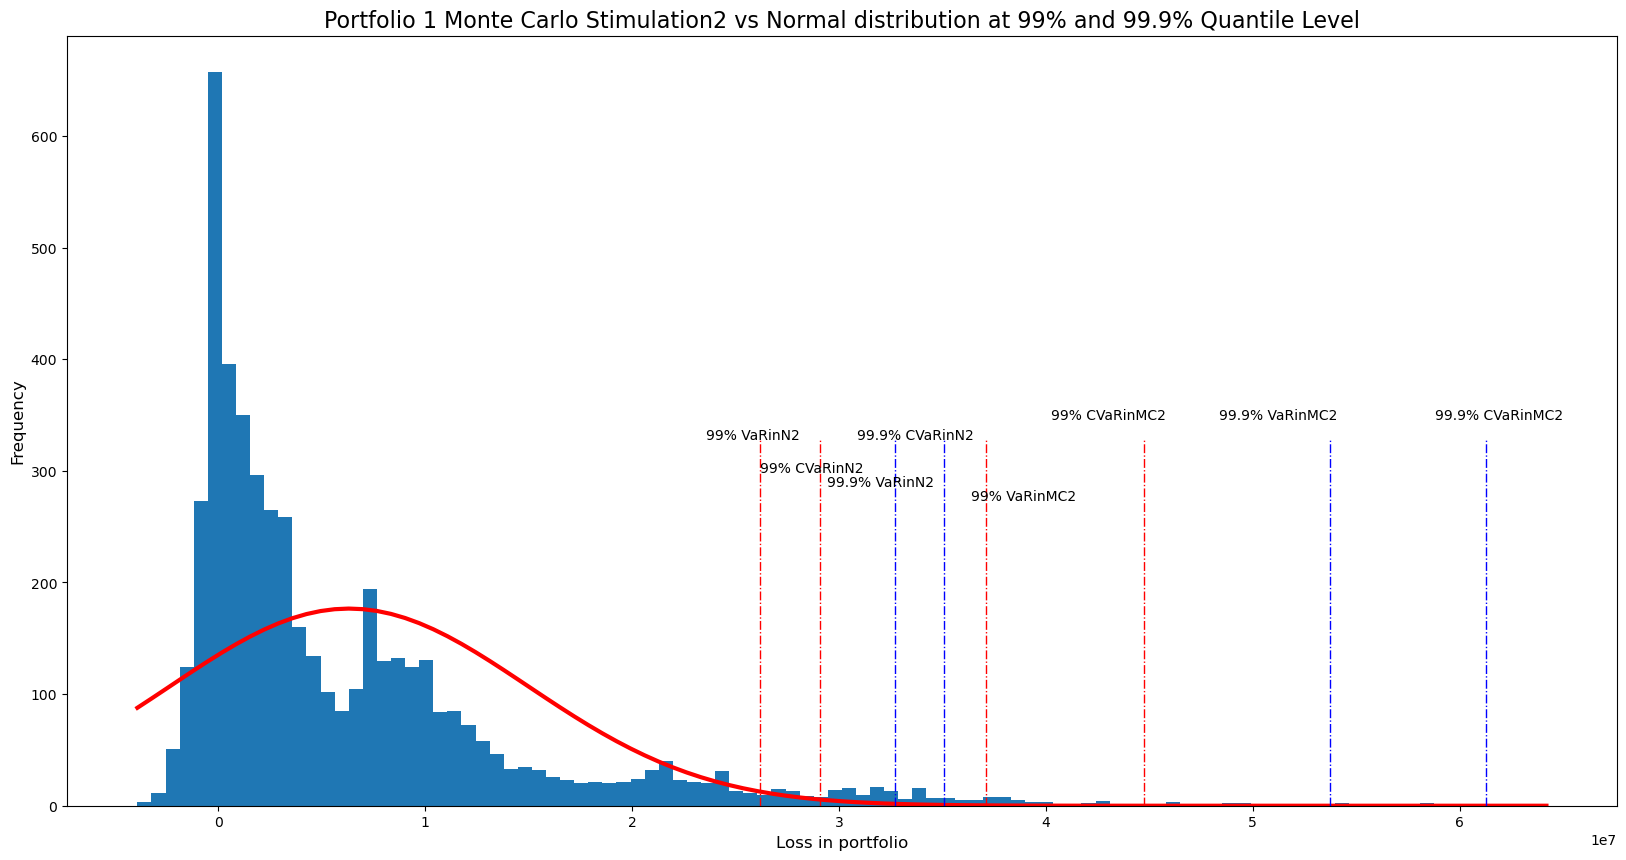

In [9]:
plt.figure(figsize=(20, 10))

frequencyCounts, binLocations, patches = plt.hist(np.dot(Losses_inMC2,x0[0]), 100)
normf= (1 / (np.std(np.dot(Losses_inMC2,x0[0])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations-np.mean(np.dot(Losses_inMC2,x0[0]))) / np.std(np.dot(Losses_inMC2,x0[0]))) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)

plt.plot(binLocations, normf, color='r', linewidth=3.0)
plt.plot([np.mean(VaRinMC2[0,0]), np.mean(VaRinMC2[0,0])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([np.mean(VaRinMC2[0,1]), np.mean(VaRinMC2[0,1])], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot([np.mean(VaRinN2[0,0]), np.mean(VaRinN2[0,0])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([np.mean(VaRinN2[0,1]), np.mean(VaRinN2[0,1])], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinMC2[0,0]), np.mean(CVaRinMC2[0,0])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinMC2[0,1]), np.mean(CVaRinMC2[0,1])], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinN2[0,0]), np.mean(CVaRinN2[0,0])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinN2[0,1]), np.mean(CVaRinN2[0,1])], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')


plt.text(0.98 * np.mean(VaRinMC2[0,0]), max(frequencyCounts) / 2.4, '99% VaRinMC2')
plt.text(0.9 * np.mean(VaRinMC2[0,1]), max(frequencyCounts) / 1.9, '99.9% VaRinMC2')
plt.text(0.9 * np.mean(VaRinN2[0,0]), max(frequencyCounts) / 2.0, '99% VaRinN2')
plt.text(0.9 * np.mean(VaRinN2[0,1]), max(frequencyCounts) / 2.3, '99.9% VaRinN2')
plt.text(0.9 * np.mean(CVaRinMC2[0,0]), max(frequencyCounts) / 1.9, '99% CVaRinMC2')
plt.text(0.96 * np.mean(CVaRinMC2[0,1]), max(frequencyCounts) / 1.9, '99.9% CVaRinMC2')
plt.text(0.9 * np.mean(CVaRinN2[0,0]), max(frequencyCounts) / 2.2, '99% CVaRinN2')
plt.text(0.88 * np.mean(CVaRinN2[0,1]), max(frequencyCounts) / 2.0, '99.9% CVaRinN2')
plt.xlabel('Loss in portfolio',fontsize=12)
plt.ylabel('Frequency',fontsize=12)
plt.title('Portfolio 1 Monte Carlo Stimulation2 vs Normal distribution at 99% and 99.9% Quantile Level',fontsize=16)
plt.show()

## Portfolio 2 Out-of-Sample vs Normal model at 99% and 99.9% level

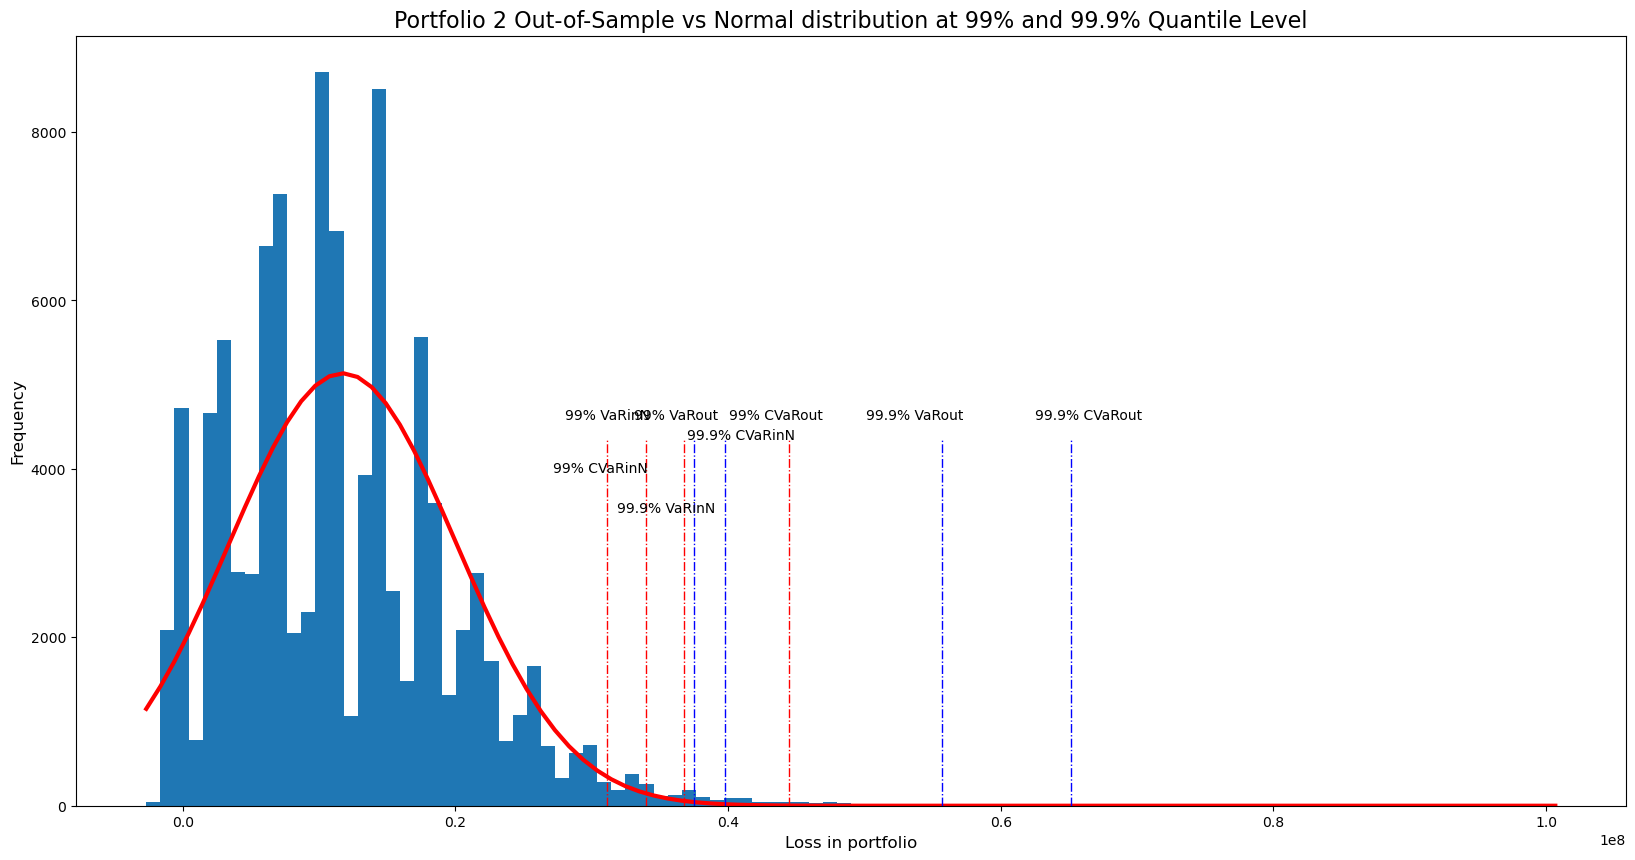

In [10]:
plt.figure(figsize=(20, 10))

frequencyCounts, binLocations, patches = plt.hist(np.dot(Losses_out,x0[1]), 100)
normf= (1 / (np.std(np.dot(Losses_out,x0[1])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations-np.mean(np.dot(Losses_out,x0[1]))) / np.std(np.dot(Losses_out,x0[1]))) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)

plt.plot(binLocations, normf, color='r', linewidth=3.0)
plt.plot([VaRout[1,0], VaRout[1,0]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([VaRout[1,1], VaRout[1,1]], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot([VaRinN[1,0], VaRinN[1,0]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([VaRinN[1,1], VaRinN[1,1]], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot([CVaRout[1,0], CVaRout[1,0]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([CVaRout[1,1], CVaRout[1,1]], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot([CVaRinN[1,0], CVaRinN[1,0]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([CVaRinN[1,1], CVaRinN[1,1]], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')


plt.text(0.9 * VaRout[1,0], max(frequencyCounts) / 1.9, '99% VaRout')
plt.text(0.9 * VaRout[1,1], max(frequencyCounts) / 1.9, '99.9% VaRout')
plt.text(0.9 * VaRinN[1,0], max(frequencyCounts) / 1.9, '99% VaRinN')
plt.text(0.85 * VaRinN[1,1], max(frequencyCounts) / 2.5, '99.9% VaRinN')
plt.text(0.9 * CVaRout[1,0], max(frequencyCounts) / 1.9, '99% CVaRout')
plt.text(0.96 * CVaRout[1,1], max(frequencyCounts) / 1.9, '99.9% CVaRout')
plt.text(0.8 * CVaRinN[1,0], max(frequencyCounts) / 2.2, '99% CVaRinN')
plt.text(0.93 * CVaRinN[1,1], max(frequencyCounts) / 2.0, '99.9% CVaRinN')
plt.xlabel('Loss in portfolio',fontsize=12)
plt.ylabel('Frequency',fontsize=12)
plt.title('Portfolio 2 Out-of-Sample vs Normal distribution at 99% and 99.9% Quantile Level',fontsize=16)
plt.show()

## Portfolio 2 MC1 vs Normal Distribution at 99% and 99.9% Quantile Level

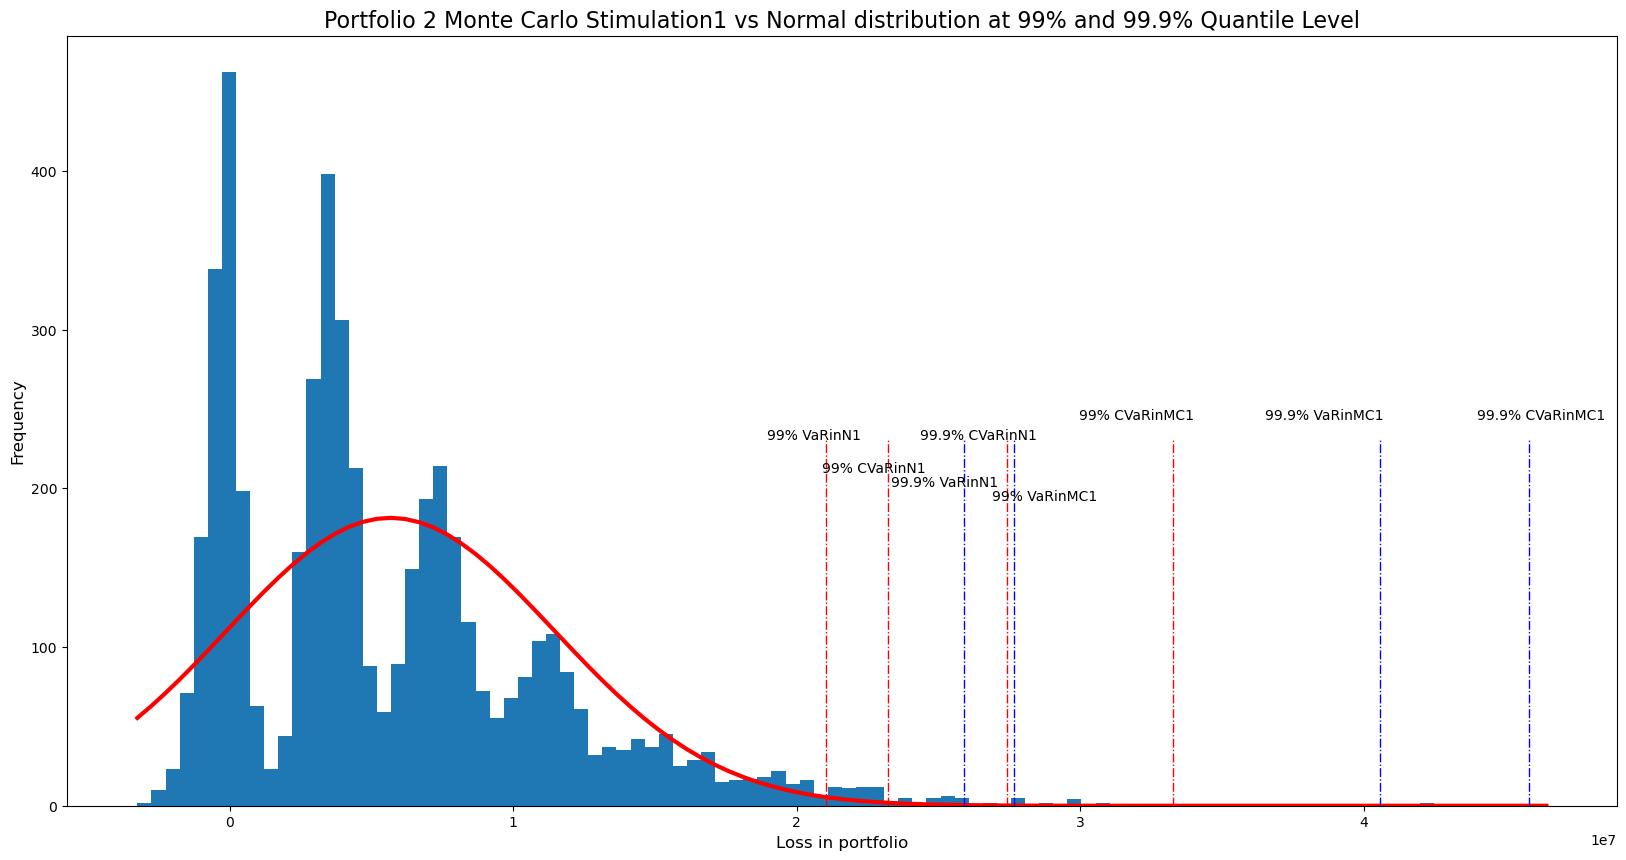

In [11]:
plt.figure(figsize=(20, 10))

frequencyCounts, binLocations, patches = plt.hist(np.dot(Losses_inMC1,x0[1]), 100)
normf= (1 / (np.std(np.dot(Losses_inMC1,x0[1])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations-np.mean(np.dot(Losses_inMC1,x0[1]))) / np.std(np.dot(Losses_inMC1,x0[1]))) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)

plt.plot(binLocations, normf, color='r', linewidth=3.0)
plt.plot([np.mean(VaRinMC1[1,0]), np.mean(VaRinMC1[1,0])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([np.mean(VaRinMC1[1,1]), np.mean(VaRinMC1[1,1])], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot([np.mean(VaRinN1[1,0]), np.mean(VaRinN1[1,0])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([np.mean(VaRinN1[1,1]), np.mean(VaRinN1[1,1])], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinMC1[1,0]), np.mean(CVaRinMC1[1,0])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinMC1[1,1]), np.mean(CVaRinMC1[1,1])], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinN1[1,0]), np.mean(CVaRinN1[1,0])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinN1[1,1]), np.mean(CVaRinN1[1,1])], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')


plt.text(0.98 * np.mean(VaRinMC1[1,0]), max(frequencyCounts) / 2.4, '99% VaRinMC1')
plt.text(0.9 * np.mean(VaRinMC1[1,1]), max(frequencyCounts) / 1.9, '99.9% VaRinMC1')
plt.text(0.9 * np.mean(VaRinN1[1,0]), max(frequencyCounts) / 2.0, '99% VaRinN1')
plt.text(0.9 * np.mean(VaRinN1[1,1]), max(frequencyCounts) / 2.3, '99.9% VaRinN1')
plt.text(0.9 * np.mean(CVaRinMC1[1,0]), max(frequencyCounts) / 1.9, '99% CVaRinMC1')
plt.text(0.96 * np.mean(CVaRinMC1[1,1]), max(frequencyCounts) / 1.9, '99.9% CVaRinMC1')
plt.text(0.9 * np.mean(CVaRinN1[1,0]), max(frequencyCounts) / 2.2, '99% CVaRinN1')
plt.text(0.88 * np.mean(CVaRinN1[1,1]), max(frequencyCounts) / 2.0, '99.9% CVaRinN1')
plt.xlabel('Loss in portfolio',fontsize=12)
plt.ylabel('Frequency',fontsize=12)
plt.title('Portfolio 2 Monte Carlo Stimulation1 vs Normal distribution at 99% and 99.9% Quantile Level',fontsize=16)
plt.show()

## Portfolio 2 MC2 vs Normal Distribution at 99% and 99.9% Quantile Level¶

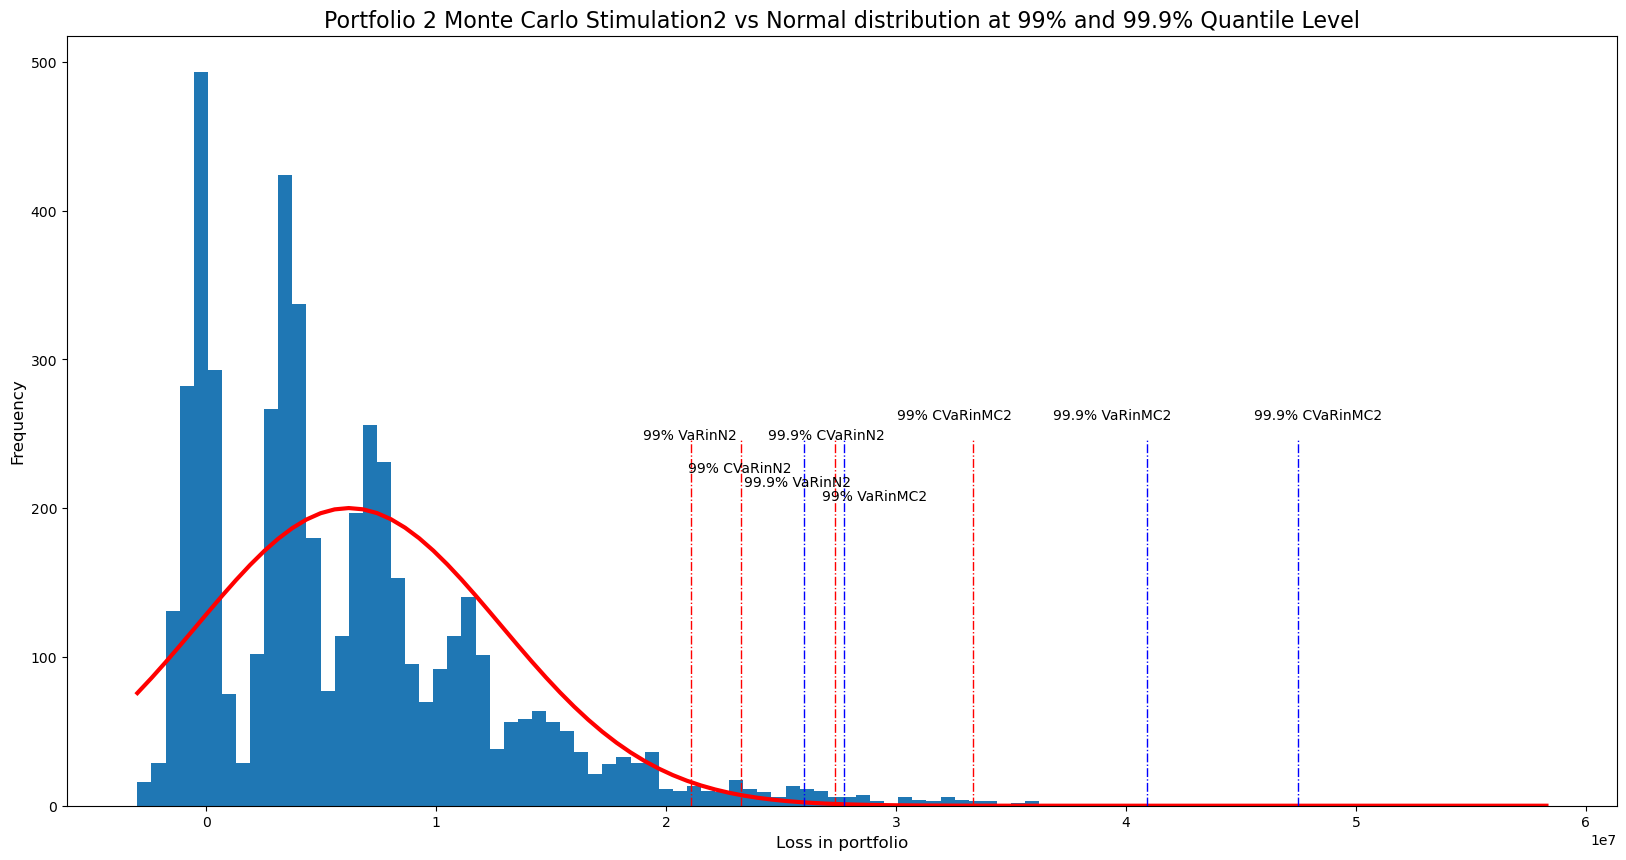

In [12]:
plt.figure(figsize=(20, 10))

frequencyCounts, binLocations, patches = plt.hist(np.dot(Losses_inMC2,x0[1]), 100)
normf= (1 / (np.std(np.dot(Losses_inMC2,x0[1])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations-np.mean(np.dot(Losses_inMC2,x0[1]))) / np.std(np.dot(Losses_inMC2,x0[1]))) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)

plt.plot(binLocations, normf, color='r', linewidth=3.0)
plt.plot([np.mean(VaRinMC2[1,0]), np.mean(VaRinMC2[1,0])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([np.mean(VaRinMC2[1,1]), np.mean(VaRinMC2[1,1])], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot([np.mean(VaRinN2[1,0]), np.mean(VaRinN2[1,0])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([np.mean(VaRinN2[1,1]), np.mean(VaRinN2[1,1])], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinMC2[1,0]), np.mean(CVaRinMC2[1,0])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinMC2[1,1]), np.mean(CVaRinMC2[1,1])], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinN2[1,0]), np.mean(CVaRinN2[1,0])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinN2[1,1]), np.mean(CVaRinN2[1,1])], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')


plt.text(0.98 * np.mean(VaRinMC2[1,0]), max(frequencyCounts) / 2.4, '99% VaRinMC2')
plt.text(0.9 * np.mean(VaRinMC2[1,1]), max(frequencyCounts) / 1.9, '99.9% VaRinMC2')
plt.text(0.9 * np.mean(VaRinN2[1,0]), max(frequencyCounts) / 2.0, '99% VaRinN2')
plt.text(0.9 * np.mean(VaRinN2[1,1]), max(frequencyCounts) / 2.3, '99.9% VaRinN2')
plt.text(0.9 * np.mean(CVaRinMC2[1,0]), max(frequencyCounts) / 1.9, '99% CVaRinMC2')
plt.text(0.96 * np.mean(CVaRinMC2[1,1]), max(frequencyCounts) / 1.9, '99.9% CVaRinMC2')
plt.text(0.9 * np.mean(CVaRinN2[1,0]), max(frequencyCounts) / 2.2, '99% CVaRinN2')
plt.text(0.88 * np.mean(CVaRinN2[1,1]), max(frequencyCounts) / 2.0, '99.9% CVaRinN2')
plt.xlabel('Loss in portfolio',fontsize=12)
plt.ylabel('Frequency',fontsize=12)
plt.title('Portfolio 2 Monte Carlo Stimulation2 vs Normal distribution at 99% and 99.9% Quantile Level',fontsize=16)
plt.show()

Build tables for errors

MC approximations (16 rows)

## Sampling Error

## Portfolio 1

In [13]:
sample_error1_var99_MC1 = (abs(np.mean(VaRinMC1[0,0]) - VaRout[0,0])/VaRout[0,0]) * 100
sample_error1_var999_MC1 = (abs(np.mean(VaRinMC1[0,1]) - VaRout[0,1])/VaRout[0,1]) * 100
sample_error1_cvar99_MC1 = (abs(np.mean(CVaRinMC1[0,0]) - CVaRout[0,0])/CVaRout[0,0]) * 100
sample_error1_cvar999_MC1 = (abs(np.mean(CVaRinMC1[0,1]) - CVaRout[0,1])/CVaRout[0,1]) * 100
sample_error1_var99_MC2 = (abs(np.mean(VaRinMC2[0,0]) - VaRout[0,0])/VaRout[0,0]) * 100
sample_error1_var999_MC2 = (abs(np.mean(VaRinMC2[0,1]) - VaRout[0,1])/VaRout[0,1]) * 100
sample_error1_cvar99_MC2 = (abs(np.mean(CVaRinMC2[0,0]) - CVaRout[0,0])/CVaRout[0,0]) * 100
sample_error1_cvar999_MC2 = (abs(np.mean(CVaRinMC2[0,1]) - CVaRout[0,1])/CVaRout[0,1]) * 100

## Portfolio 2

In [14]:
sample_error2_var99_MC1 = (abs(np.mean(VaRinMC1[1,0]) - VaRout[1,0])/VaRout[1,0]) * 100
sample_error2_var999_MC1 = (abs(np.mean(VaRinMC1[1,1]) - VaRout[1,1])/VaRout[1,1]) * 100
sample_error2_cvar99_MC1 = (abs(np.mean(CVaRinMC1[1,0]) - CVaRout[1,0])/CVaRout[1,0]) * 100
sample_error2_cvar999_MC1 = (abs(np.mean(CVaRinMC1[1,1]) - CVaRout[1,1])/CVaRout[1,1]) * 100
sample_error2_var99_MC2 = (abs(np.mean(VaRinMC2[1,0]) - VaRout[1,0])/VaRout[1,0]) * 100
sample_error2_var999_MC2 = (abs(np.mean(VaRinMC2[1,1]) - VaRout[1,1])/VaRout[1,1]) * 100
sample_error2_cvar99_MC2 = (abs(np.mean(CVaRinMC2[1,0]) - CVaRout[1,0])/CVaRout[1,0]) * 100
sample_error2_cvar999_MC2 = (abs(np.mean(CVaRinMC2[1,1]) - CVaRout[1,1])/CVaRout[1,1]) * 100

In [15]:
distribution = ['Portfolio1 MC1(99% VaR)', 'Portfolio1 MC1(99.9% VaR)', 'Portfolio1 MC1(99% CVaR)', 'Portfolio1 MC1(99.9% CVaR)', 'Portfolio1 MC2(99% VaR)', 'Portfolio1 MC2(99.9% VaR)', 'Portfolio1 MC2(99% CVaR)', 'Portfolio1 MC2(99.9% CVaR)',
        'Portfolio2 MC1(99% VaR)', 'Portfolio2 MC1(99.9% VaR)', 'Portfolio2 MC1(99% CVaR)', 'Portfolio2 MC1(99.9% CVaR)', 'Portfolio2 MC2(99% VaR)', 'Portfolio2 MC2(99.9% VaR)', 'Portfolio2 MC2(99% CVaR)', 'Portfolio2 MC2(99.9% CVaR)']
df_mc = pd.DataFrame({'Portfolio Distribution': distribution, 'Sampling Error(%)':[sample_error1_var99_MC1, sample_error1_var999_MC1, sample_error1_cvar99_MC1, sample_error1_cvar999_MC1,
                                      sample_error1_var99_MC2, sample_error1_var999_MC2, sample_error1_cvar99_MC2, sample_error1_cvar999_MC2, 
                                      sample_error2_var99_MC1, sample_error2_var999_MC1, sample_error2_cvar99_MC1, sample_error2_cvar999_MC1,
                                      sample_error2_var99_MC2, sample_error2_var999_MC2, sample_error2_cvar99_MC2, sample_error2_cvar999_MC2]})
df_mc

,Portfolio Distribution,Sampling Error(%)
0,Portfolio1 MC1(99% VaR),14.745901
1,Portfolio1 MC1(99.9% VaR),16.951261
2,Portfolio1 MC1(99% CVaR),13.963657
3,Portfolio1 MC1(99.9% CVaR),17.282284
4,Portfolio1 MC2(99% VaR),14.526685
5,Portfolio1 MC2(99.9% VaR),16.860004
6,Portfolio1 MC2(99% CVaR),13.345626
7,Portfolio1 MC2(99.9% CVaR),16.451276
8,Portfolio2 MC1(99% VaR),25.328040
9,Portfolio2 MC1(99.9% VaR),27.115125


## Model Error

## Portfolio 1

In [16]:
model_error1_var99_N1 = (abs(np.mean(VaRinN1[0,0]) - VaRout[0,0])/VaRout[0,0]) * 100
model_error1_var999_N1 = (abs(np.mean(VaRinN1[0,1]) - VaRout[0,1])/VaRout[0,1]) * 100
model_error1_cvar99_N1 = (abs(np.mean(CVaRinN1[0,0]) - CVaRout[0,0])/CVaRout[0,0]) * 100
model_error1_cvar999_N1 = (abs(np.mean(CVaRinN1[0,1]) - CVaRout[0,1])/CVaRout[0,1]) * 100
model_error1_var99_N2 = (abs(np.mean(VaRinN2[0,0]) - VaRout[0,0])/VaRout[0,0]) * 100
model_error1_var999_N2 = (abs(np.mean(VaRinN2[0,1]) - VaRout[0,1])/VaRout[0,1]) * 100
model_error1_cvar99_N2 = (abs(np.mean(CVaRinN2[0,0]) - CVaRout[0,0])/CVaRout[0,0]) * 100
model_error1_cvar999_N2 = (abs(np.mean(CVaRinN2[0,1]) - CVaRout[0,1])/CVaRout[0,1]) * 100

## Portfolio 2

In [17]:
model_error2_var99_N1 = (abs(np.mean(VaRinN1[1,0]) - VaRout[1,0])/VaRout[1,0]) * 100
model_error2_var999_N1 = (abs(np.mean(VaRinN1[1,1]) - VaRout[1,1])/VaRout[1,1]) * 100
model_error2_cvar99_N1 = (abs(np.mean(CVaRinN1[1,0]) - CVaRout[0,0])/CVaRout[1,0]) * 100
model_error2_cvar999_N1 = (abs(np.mean(CVaRinN1[1,1]) - CVaRout[1,1])/CVaRout[1,1]) * 100
model_error2_var99_N2 = (abs(np.mean(VaRinN2[1,0]) - VaRout[1,0])/VaRout[1,0]) * 100
model_error2_var999_N2 = (abs(np.mean(VaRinN2[1,1]) - VaRout[0,1])/VaRout[1,1]) * 100
model_error2_cvar99_N2 = (abs(np.mean(CVaRinN2[1,0]) - CVaRout[0,0])/CVaRout[1,0]) * 100
model_error2_cvar999_N2 = (abs(np.mean(CVaRinN2[1,1]) - CVaRout[0,1])/CVaRout[1,1]) * 100

In [18]:
distribution = ['Portfolio1 N1(99% VaR)', 'Portfolio1 N1(99.9% VaR)', 'Portfolio1 N1(99% CVaR)', 'Portfolio1 N1(99.9% CVaR)', 'Portfolio1 N2(99% VaR)', 'Portfolio1 N2(99.9% VaR)', 'Portfolio1 N2(99% CVaR)', 'Portfolio1 N2(99.9% CVaR)',
        'Portfolio2 N1(99% VaR)', 'Portfolio2 N1(99.9% VaR)', 'Portfolio2 N1(99% CVaR)', 'Portfolio2 N1(99.9% CVaR)', 'Portfolio2 N2(99% VaR)', 'Portfolio2 N2(99.9% VaR)', 'Portfolio2 N2(99% CVaR)', 'Portfolio2 N2(99.9% CVaR)']
df_N = pd.DataFrame({'Portfolio Normal Distribution': distribution, 'Modeling Error': [model_error1_var99_N1, model_error1_var999_N1, model_error1_cvar99_N1, model_error1_cvar999_N1, model_error1_var99_N2, model_error1_var999_N2,
                                                                                      model_error1_cvar99_N2, model_error1_cvar999_N2, model_error2_var99_N1, model_error2_var999_N1, model_error2_cvar99_N1, model_error2_cvar999_N1, model_error2_var99_N2, model_error2_var999_N2, model_error2_cvar99_N2, model_error2_cvar999_N2]})
df_N

,Portfolio Normal Distribution,Modeling Error
0,Portfolio1 N1(99% VaR),39.859967
1,Portfolio1 N1(99.9% VaR),49.577280
2,Portfolio1 N1(99% CVaR),43.838028
3,Portfolio1 N1(99.9% CVaR),52.338677
4,Portfolio1 N2(99% VaR),39.656649
5,Portfolio1 N2(99.9% VaR),49.412375
6,Portfolio1 N2(99% CVaR),43.651249
7,Portfolio1 N2(99.9% CVaR),52.184225
8,Portfolio2 N1(99% VaR),42.713527
9,Portfolio2 N1(99.9% VaR),53.462422
